# Simple Neural Network

In [1]:
# Import necessary packages

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt

from utils import load_posistions, load_data

## Data preparation
1. Create dataset class
2. Vectorize CSI to use it as input
3. Create loader to iterate over the dataset

### Dataset

In [2]:
class CSIDataset(Dataset):
    """CSI dataset."""
    
    def __init__(self, positions_file, samples_dir, indices_file):
        """
        Args:
            positions_file (string): Path to the file containing the user positions.
            samples_dir (string): Directory containing the samples.
            indexes_file (string): Path to the file holding the indexes to be considered for the set
        """
        self.user_positions = load_data(positions_file)
        self.samples_dir = samples_dir
        self.indices = load_data(indices_file)
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        index = self.indices[idx]
        
        sample_filepath = os.path.join(self.samples_dir, 'channel_measurement_{:06d}.npy'.format(index))
        sample = load_data(sample_filepath)
                    
        # Remove z coordinate from the positions
        label = np.delete(self.user_positions[index], -1)
        
        return sample, label

### Vectorize sample
Each sample $\hat h\in\mathbb{C}^{64\times100}$ for the 64 antennas and 100 subcarriers. <br>
Since each sample is a complex matrix, it is necessary to vectorize it to use it as input for the neural network. This is done first by concatenating the CSI values of each antenna into a vector:
$$
\textbf{h}_k=\begin{bmatrix}
h_{k,1}\\
h_{k,2}\\
\vdots\\
h_{k,100}
\end{bmatrix} \text{ for } k\in\{1,...,64\}
$$
Then concatenating each $\textbf{h}_k$ into a vector of size 6400:
$$
\hat{\textbf{h}}=\begin{bmatrix}
\textbf{h}_1\\
\textbf{h}_2\\
\vdots\\
\textbf{h}_{64}
\end{bmatrix}=\begin{bmatrix}
h_{1,1}\\
\vdots\\
h_{1,100}\\
h_{2,1}\\
\vdots\\
h_{2,100}\\
\vdots\\
h_{64,1}\\
\vdots\\
h_{64,100}
\end{bmatrix}
$$
Finally, since Pytorch cannot handle complex numbers, it is necessary to tranform each CSI value $h$ into $h' =\begin{bmatrix}real(h)\\ imag(h)\end{bmatrix}$. <br>
Thus, the final vector $\hat{\textbf h}$ is:
$$
\hat{\textbf h}=
\begin{bmatrix}
real(h_{1,1})\\
imag(h_{1,1})\\
\vdots\\
real(h_{1,100})\\
imag(h_{1,100})\\
real(h_{2,1})\\
imag(h_{2,1})\\
\vdots\\
real(h_{2,100})\\
imag(h_{2,100})\\
\vdots\\
real(h_{64,1})\\
imag(h_{64,1})\\
\vdots\\
real(h_{64,100})\\
imag(h_{64,100})
\end{bmatrix},
$$
which is a $12800\times1$ vector.

In [3]:
def vectorize_samples(samples):
    # concatenate into one 6400x1 vector
    samples = torch.flatten(samples, start_dim=1)
    # split complex values
    samples = torch.stack((samples.real, samples.imag), -1) # vector is now 6400x2
    # concatenate into one 12800x1 vector
    samples = torch.flatten(samples, start_dim=1)
    return samples

In [4]:
train_dataset = CSIDataset(
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/user_positions.npy',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/samples',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/train_indices.npy'
)
test_dataset = CSIDataset(
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/user_positions.npy',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/samples',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/test_indices.npy'
)
print(len(train_dataset), len(test_dataset), len(train_dataset) + len(test_dataset))

201568 50436 252004


### Dataloader
Dataloader allows for some useful features when iterating over the dataset [\[1\]](#1), such as
* Batching the data
* Shuffling the data
* Loading the data in parallel using multiprocessing workers

In [5]:
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=8)

## Neural network model

In [6]:
from torch import nn
#import torch.nn.functional as F

**Normalize to avoid exploding gradient**

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            #nn.BatchNorm1d(12800),
            nn.Linear(12800, 8000),
            nn.ReLU(),
            nn.Linear(8000, 4000),
            nn.ReLU(),
            nn.Linear(4000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            
            nn.Linear(100, 2)
        )
        
    def forward(self, x):
        out = self.model(x)
        return out

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0.01)

model = Network()
#model.apply(init_weights)
model

Network(
  (model): Sequential(
    (0): Linear(in_features=12800, out_features=8000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8000, out_features=4000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4000, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=500, bias=True)
    (7): ReLU()
    (8): Linear(in_features=500, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=2, bias=True)
  )
)

## Training the model

In [9]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
model.to(device)
device.type

'cuda'

In [10]:
# Define the loss
criterion = nn.MSELoss()
# Define optimizer to update weights (stochastic gradient descent)
optimizer = optim.SGD(model.parameters(), lr=0.001)

epochs = 50
training_losses = []
testing_losses = []
for e in range(epochs):
    training_loss = 0
    testing_loss = 0
    for samples, labels in train_loader:
        
        samples, labels = samples.to(device), labels.to(device)
        
        # Vectorize the samples
        samples = vectorize_samples(samples)
    
        optimizer.zero_grad()
        
        output = model(samples.float())
        loss = criterion(output, labels.float())
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        training_loss += loss.item()
        #print(loss.item())
    else:
        with torch.no_grad():
            for samples, labels in test_loader:
                samples, labels = samples.to(device), labels.to(device)
        
                # Vectorize the samples
                samples = vectorize_samples(samples)

                output = model(samples.float())
                loss = criterion(output, labels.float())

                testing_loss += loss.item()
                
        training_loss /= len(train_dataset)
        testing_loss /= len(test_dataset)
        training_losses.append(training_loss)
        testing_losses.append(testing_loss)

        print("Epoch: {}/{}... ".format(e+1, epochs),
              "Training Loss: {:.3f}... ".format(training_loss),
              "Test Loss: {:.3f}... ".format(testing_loss))
        



Epoch: 1/50...  Training Loss: 2022.045...  Test Loss: 2039.582... 
Epoch: 2/50...  Training Loss: 2017.396...  Test Loss: 2029.247... 
Epoch: 3/50...  Training Loss: 1988.123...  Test Loss: 1969.271... 
Epoch: 4/50...  Training Loss: 1869.132...  Test Loss: 1767.506... 
Epoch: 5/50...  Training Loss: 1545.483...  Test Loss: 1293.925... 
Epoch: 6/50...  Training Loss: 935.960...  Test Loss: 577.699... 
Epoch: 7/50...  Training Loss: 369.395...  Test Loss: 283.967... 
Epoch: 8/50...  Training Loss: 248.778...  Test Loss: 224.786... 
Epoch: 9/50...  Training Loss: 207.523...  Test Loss: 198.235... 
Epoch: 10/50...  Training Loss: 190.905...  Test Loss: 188.900... 
Epoch: 11/50...  Training Loss: 185.279...  Test Loss: 185.741... 
Epoch: 12/50...  Training Loss: 183.030...  Test Loss: 184.254... 
Epoch: 13/50...  Training Loss: 181.971...  Test Loss: 183.333... 
Epoch: 14/50...  Training Loss: 181.317...  Test Loss: 182.970... 
Epoch: 15/50...  Training Loss: 180.908...  Test Loss: 182.60

KeyboardInterrupt: 

## Test the model

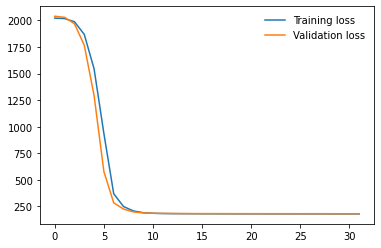

In [11]:
plt.plot(training_losses, label='Training loss')
plt.plot(testing_losses, label='Validation loss')
plt.legend(frameon=False)

### Save the model

In [16]:
torch.save(model.state_dict(), 'simple_nn')

## References
<a id='1'>\[1\]</a> https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html (29.04.2021)